# Char RNN

1. OneHot via tf.one_hot()

Note: This is the less recommended aproximation.

In [1]:
import tensorflow as tf
import NLP_Utils as nlp
import time
import numpy as np

## Hyperparams

In [2]:
#Data
filename = 'tiny_shakespeare.txt'

#Cell
state_size = 200 #Default: 200

#Batches & Vocab
batch_size = 64 #Default: 64
seq_length = 50 #Default: 50
overlap = 25 #Default 25
vocab_strategy = 'all'

#Test
test_size = 300 #Default: 300

## Read Data & Manage Batches

In [3]:
batchManager = nlp.BatchManager()
batchManager.set_params(filename,batch_size,seq_length,overlap,vocab_strategy,mode='dense')
batchManager.get_params()

num_batches = batchManager._num_batches
vocab_size = batchManager._vocab_size

@params:
[filename : "tiny_shakespeare.txt"]
[text : "First Citi"]
[text_size : 1115394]
[vocab : ['V', 'g', 'W', "'", 'N']]
[vocab_size : 65]
[mode : dense]
[batch_size : 64]
[seq_length : 50]
[overlap : 25]
[num_batches : 697]


In [4]:
batchManager.stats()

The corpus has 1115394 characters
Configuration:
[batch_size : 64]
[seq_length : 50]
[overlap : 25]

The current configuration gives us 697 batches of 64 observations each one looking 50 steps in the past and overlapping 25 steps


## Placeholders

In [5]:
seq = tf.placeholder(dtype=tf.int32,shape=[None,None],name='seq') #[Batch_size x seq_length]
seq_one_hot = tf.one_hot(seq,vocab_size,name='seq_one_hot') #El que se usa en la RNN

temperature = tf.placeholder(tf.float32)

## Create RNN cell

In [6]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=state_size)

'''
batch_size : seq.get_shape()[0] instead of 'batch_size' 
in order to work with variable seq length, this is, for testing char by char
'''
zero_state = cell.zero_state(batch_size=tf.shape(seq)[0],dtype=tf.float32) 


in_state = tf.placeholder_with_default(input=zero_state,shape=[None,state_size])

In [7]:
output, out_state = tf.nn.dynamic_rnn(cell=cell,inputs=seq_one_hot,initial_state=in_state)

## Create model

In [8]:
logits= tf.contrib.layers.fully_connected(inputs=output,num_outputs=vocab_size,activation_fn=None)

loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=logits[:,:-1],labels=seq_one_hot[:,1:]))

sample = tf.multinomial(logits=logits[:,-1],num_samples=1)[:,0]

In [9]:
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

## Train

In [10]:
num_epochs = 10

display_freq = num_batches//10

loss_list = list()
av_loss_list = list()

step = 0

last_epoch = -1

with tf.Session() as sess:
    start = time.time()
    tf.global_variables_initializer().run()
    
    for batchX,batchY,epoch in batchManager.generate_batches(num_epochs=num_epochs):
        
        if(last_epoch != epoch):
            print('Epoch %d:' % epoch)
            last_epoch = epoch
        
        
        _loss,_,_ = sess.run([loss,optimizer,seq_one_hot],{seq:batchX})
        
        loss_list.append(_loss)
        
        
        if(step % display_freq == 0):            
            if len(loss_list)>1: av_loss_list.append(np.average(a=loss_list[-display_freq]))
            
            print('At step %d:%d - Loss: %.2f - Elapsed time: %s' %(epoch,step,_loss,(time.time()-start)))
            
            ###TEST###
            sentence = 'A'
            state = None
            for _ in range(test_size):
                batch = [batchManager.vocab_encode(sentence[-1])] #Last character in sentence
                feed = {seq : batch}
                
                if state is not None: #First is none and must be None
                    feed.update({in_state:state})
                
                index,state = sess.run([sample,out_state],feed)
                sentence += batchManager.vocab_decode(index)
            print(sentence,'\n')
            ##########
            start = time.time()
            
        step += 1
            
            
        
        

Epoch 0:
At step 0:0 - Loss: 13144.32 - Elapsed time: 2.380671739578247
ABWREKT3Qb$ MKIMpJCl;BRbPdmrzvDtv;3 HO n;dPZxMZR:z UGip?XMpKScBw'PYRC'NzDOuuRDDpNAptSEzJi-GkJGm;VU!'itds YVehIkwF.nKYfeRloLRPBsq?xd?Fnbs:osePrZOLvbxj.:Y-:yc'EXZUG$!3!vLrZ&J  iOCFQFvm-:Hn$KEq GTlaHsgOYenzC3yPPUzIEBXMIaFqu-hijQzpaabv
EKoi:DUR:vGUMfgzPYfvlQclGKozfuwKPOyk$j&C.zn3JF3mAZouU.r!pG,,cNcW-!i,? 

At step 0:69 - Loss: 9367.64 - Elapsed time: 5.791505336761475
AujYU :
a 
Wsmy 
ems toydl nnrh
t ooe cttsOsuUonnwf ware nne ss ureoa hrIee nr ,apns  ioaPhop Bhvp eouhctmnn turfpihyste
aer reAee etrenohhulehsti atsSdh.gltaalitn ,rt jorme
ou hiph
tssR
rOs hslsdwruiun thn,e. guylmay mars lhfer MI veslthp ea hl'I 
or
o'wvC lnOwf oosS ahe n'os toun
e:Ltaeu  yutvd yT  

At step 0:138 - Loss: 8685.32 - Elapsed time: 5.810530185699463
Ad uoodat muuf and ws  hest atThe cou?wdst fayhenefan Mtw nr oo d,t ghru cotd mhie gfxe me cr dod

chiEescWpad  nit &ou,el! laMarnsg iitibnp;my the bsofet  irhe .rlF andtt, ioldomB:
WhI  nfiy g

At step 2:1587 - Loss: 6477.24 - Elapsed time: 5.799516201019287
Ad. I I I, Whith reappming ign:
I waller gety I word comat, and berd my may:
Sersord Usperee guchs in and
Sspard de plandise dastrondrof's mo corde sond isin,
Wel' the souch the servener to munk nond, AFirel'o: as in titE hat hered fis ellartstad ank y all O nor?

KING,
ICH:I'l ovvermer,
When sour bl 

At step 2:1656 - Loss: 6188.86 - Elapsed time: 5.803520202636719
Ard then sail nom ofred!
Hive wers ngo doricg'd enen my coost dt! Oe frect,oue ar lave,
End west m Sinj, ty uhed, theleling ast with soud!
How spore ftom ank Iel-?

Dart,
God alm not is mon' nee stake you sod
Mascere of my diswile, lege hosh aganoondar,
And ous wad by that heanss, stowster to sw, ad  

At step 2:1725 - Loss: 6059.39 - Elapsed time: 5.861584663391113
AN:
Shes tich oid lisst, atr ann cranke, sean!
Not ward and stivad say II challo t at of ulk hourer,
How y sread, beay bey'sce,
Tr youn aro mest on Mare of eres,
An. Jule tous reate! wille, thimed,

At step 4:3174 - Loss: 5284.91 - Elapsed time: 5.791506290435791
As to day cangond's light?
I have for andet plaighreds yourd;
Noren peorefare holdwers of merdow,
suls slisk, in dease
To dinticcestered heed-voredeat be twould thee ouckeadiece
With hore oftishel blomy.

BORI RONER:
Go; you livel he mo headd onerifo cisse what will if I righ, whather yofreet of Kind 

At step 4:3243 - Loss: 5954.71 - Elapsed time: 5.791506290435791
A prod and mantarsel, myoull not
and leepono go earus 'staraith mancusen to ntichart't shave will ghear io hish in you:
'ol'd, I he wan to tint now rusalust; for a wers
Withredings to oun briken tifl her
'domesh porsund appasse,
And in are it munton!

CLARI HVETVORF:
My tik! my series!
Sow, broy desc 

At step 4:3312 - Loss: 5389.36 - Elapsed time: 5.956692218780518
ADd IG turmess to of the wert:
Weth
agun the rave yeliger will's witkno.

oult promandefor, goung my ffich you?

YELO:
Be'd mase futlepus bet it wick do dreford;--a

Astrota? 'liven So the sends en

At step 6:4761 - Loss: 5138.57 - Elapsed time: 5.8185365200042725
Ald pishaid of sin
shick be much ofthing, not
Or how's arrying hald are the ansalt'd wagshalf and to sie? grier, sollon, if uawnedsechsse culfarest of glooder of the owmiliale,
:
Wilk do a takking of thin
 inturiclluin your, is craicen's fureth, favingrit;

Cand do to knever flit will have worly trak 

At step 6:4830 - Loss: 5641.71 - Elapsed time: 5.812529802322388
Ame retore at threed hoo's.

PAUFLO:
O, dety harghtot's betime, think unoun
To bescien stell you Pall, my leave with your offentrow, my coming. Wallokes the would wat speatentel, recaleco, and witlons,
I may beforth the met you and hit bufthen
That, her boong mo talk?

SABOLLE:
Ash you tell in the wo 

Epoch 7:
At step 7:4899 - Loss: 5725.76 - Elapsed time: 7.781740665435791
ANNIA:
Some clack falyer?
The swoy dost yoursedm,
Andectule.

MARIMIA:
Whecemenior:
If here ofrit he kind?

Firawsms.
Be a mord his woughtreisase from in thentepinow farch, they, came him

At step 9:6348 - Loss: 5234.91 - Elapsed time: 5.799515724182129
A ITw:
He-velond
Unould to a yous,
That I am should being hee I hill a some heagt!

Siclifizen:
Hersiome--mastle on; but ind twein the cure.

BERTIUS:
I have my pricone master: scole be thies
and well, hi'
bave upon me?

Cond LIUS:
Duch a vives molk puspatather's: voich:
I have not baster,
And he, wo 

At step 9:6417 - Loss: 5111.91 - Elapsed time: 5.784498453140259
A great giver me dear?

CLARENCE:
Gootheremonge, my souch!
She way accound my offood lord,
His maright that copthints, feire, my ton?
Seld byee up thou sakenge Erward free sie,
URxmect amsinds, emblt gevily wellow tazen?

Beyour I will turte, or buught impleigh.

Fiost Murjurtt. Of lass thee thereeis 

At step 9:6486 - Loss: 5186.45 - Elapsed time: 5.800515413284302
AUT:
What, and whak I will'. Hast himble dute?

Fforn Cannot down a creent or must to with his, might kidgest his.

ne sony flirm timese vidwaids to me?

MONGORI
CIRIAN:
Good rabes anm ghrdends?

R

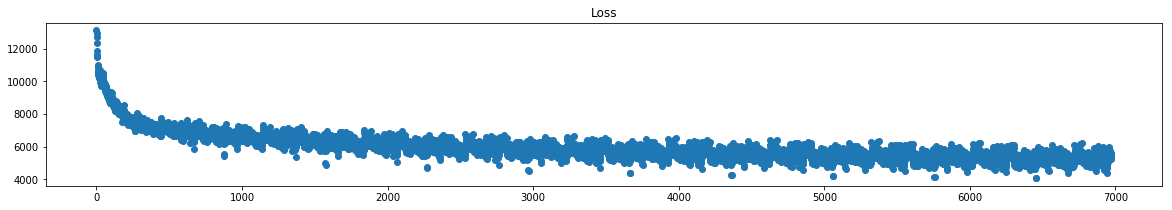

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,3))
plt.title('Loss')
plt.scatter(x=range(len(loss_list)),y=loss_list)
plt.show()

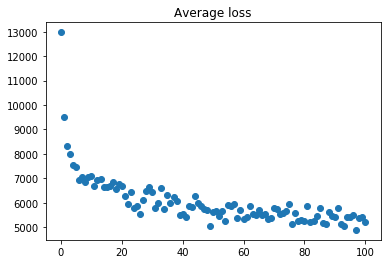

In [12]:
plt.title('Average loss')
plt.scatter(x=range(len(av_loss_list)),y=av_loss_list)
plt.show()